# **Transfer Learning with VGG-19 model**

## Loading Data & Dynamic Augmentations

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

dataset_dir = r"D:\Suvan's Projects\FYP\EditAugment"

# Resize images to 224x224 as required by VGG-19
imageSize = (224, 224)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Random zooming
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Adjust brightness randomly
)

# Normalization only for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

stressTest_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "stressTest"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

Found 1455 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
Found 252 images belonging to 4 classes.


## Loading & Re-training VGG 19 model

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4009 - loss: 1.3041 - val_accuracy: 0.6562 - val_loss: 0.6944
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6984 - loss: 0.6990 - val_accuracy: 0.7500 - val_loss: 0.5293
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8216 - loss: 0.4895 - val_accuracy: 0.8594 - val_loss: 0.3293
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9209 - loss: 0.2298 - val_accuracy: 0.8281 - val_loss: 0.4761
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8983 - loss: 0.2866 - val_accuracy: 0.9531 - val_loss: 0.1731
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.9678 - loss: 0.1010 - val_accuracy: 0.9062 - val_loss: 0.3247
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9706 - loss: 0.1053 - val_accuracy: 0.9531 - val_loss: 0.1912
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9726 - loss: 0.0808 - val_accuracy: 0.9375 - v

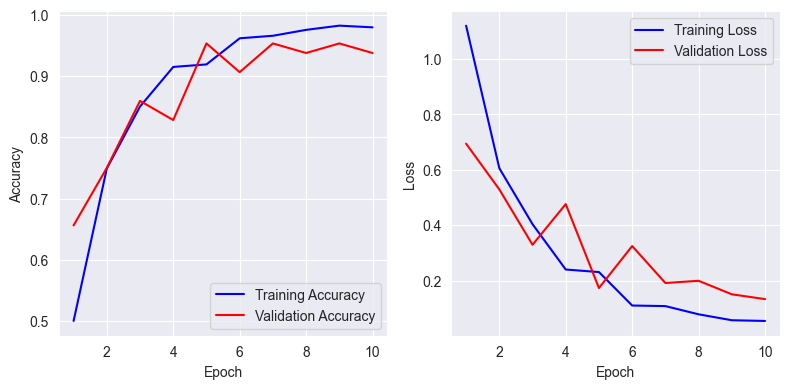

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9261 - loss: 0.2392
Test Accuracy: 0.9048
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8946 - loss: 0.3797
Stress Test Accuracy: 0.8968


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224,3))

# Freeze all layers except last 5 for re-training
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Define input shape explicitly
inputs = Input(shape=(224, 224, 3))

# Connect base model
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Plotting the accuracy/epoch loss
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1,len(acc2) +1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (8,4))
axes[0].plot(epochs, acc2, 'b', label= 'Training Accuracy')
axes[0].plot(epochs, val_acc2, 'r', label= 'Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label= 'Training Loss')
axes[1].plot(epochs, val_loss2, 'r', label= 'Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# Evaluate on test & stress-test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print(f"Stress Test Accuracy: {stress_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


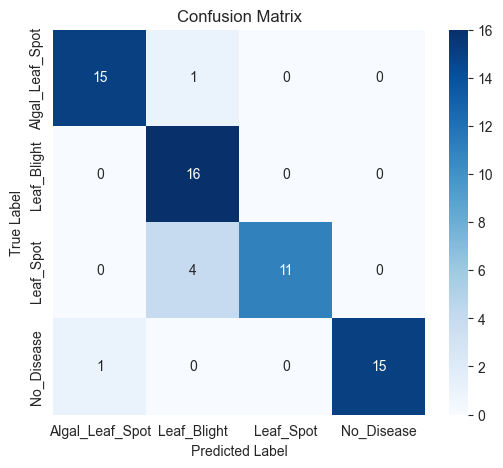

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.94      0.94      0.94        16
    Leaf_Blight       0.76      1.00      0.86        16
      Leaf_Spot       1.00      0.73      0.85        15
     No_Disease       1.00      0.94      0.97        16

       accuracy                           0.90        63
      macro avg       0.92      0.90      0.90        63
   weighted avg       0.92      0.90      0.90        63

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9261 - loss: 0.2392
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9062 - loss: 0.3384
Test Accuracy       : 90.48%
Stress Test Accuracy: 90.48%


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Get the true labels from the validation generator
true_labels = test_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

## Unfreezing Layers to Fine-Tune Model

In [20]:
# Unfreeze LAST 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again
model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9840 - loss: 0.0477 - val_accuracy: 0.9844 - val_loss: 0.0502
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9947 - loss: 0.0137 - val_accuracy: 0.9844 - val_loss: 0.0744
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9960 - loss: 0.0171 - val_accuracy: 0.9688 - val_loss: 0.0911
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9998 - loss: 0.0067 - val_accuracy: 0.9688 - val_loss: 0.0961
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9921 - loss: 0.0201 - val_accuracy: 0.9688 - val_loss: 0.1456
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9688 - val_loss: 0.1217
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9989 - loss: 0.0074 - val_accuracy: 0.9688 - val_loss: 0.0830
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9990 - loss: 0.0082 - val_accuracy: 0.9844 - v

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E784969F80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


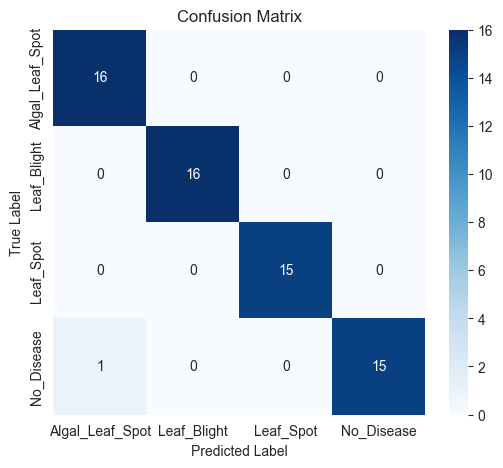

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.94      1.00      0.97        16
    Leaf_Blight       1.00      1.00      1.00        16
      Leaf_Spot       1.00      1.00      1.00        15
     No_Disease       1.00      0.94      0.97        16

       accuracy                           0.98        63
      macro avg       0.99      0.98      0.98        63
   weighted avg       0.99      0.98      0.98        63

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9894 - loss: 0.1320
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9641 - loss: 0.1353
Test Accuracy       : 98.41%
Stress Test Accuracy: 96.03%


In [21]:
true_labels = test_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

Stress Test Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


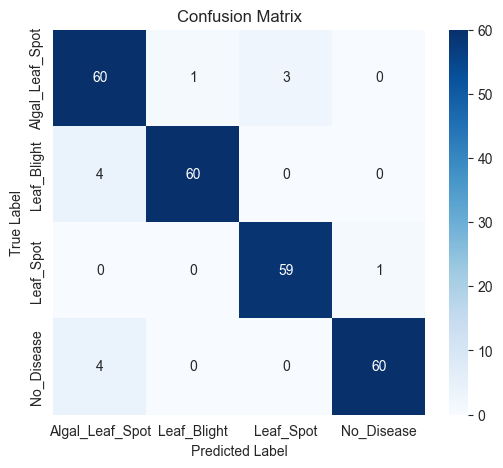

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.88      0.94      0.91        64
    Leaf_Blight       0.98      0.94      0.96        64
      Leaf_Spot       0.95      0.98      0.97        60
     No_Disease       0.98      0.94      0.96        64

       accuracy                           0.95       252
      macro avg       0.95      0.95      0.95       252
   weighted avg       0.95      0.95      0.95       252



In [22]:
true_labels = stressTest_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(stressTest_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(stressTest_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

# **Saving models as Keras & TFLite formats**

In [23]:
# Saving the model
model.save("model/VGG19_bestModel.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,299,918 (149.92 MB)

 Trainable params: 9,571,588 (36.51 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

 Optimizer params: 19,143,178 (73.03 MB)

In [24]:
from tensorflow.keras.models import load_model

model_path = 'model/VGG19_bestModel.keras'
model = load_model(model_path)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9894 - loss: 0.1320
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9522 - loss: 0.1149
Test Accuracy       : 98.41%
Stress Test Accuracy: 95.24%


In [25]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model('model/VGG19_bestModel.keras')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
with open('model/VGG19_bestModel.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Travi\AppData\Local\Temp\tmp12e71tuk\assets


INFO:tensorflow:Assets written to: C:\Users\Travi\AppData\Local\Temp\tmp12e71tuk\assets


Saved artifact at 'C:\Users\Travi\AppData\Local\Temp\tmp12e71tuk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2090806906512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090806910736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090806904784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090806913808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090806905552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090806904976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090456904144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090456903952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090456895888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090456905872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090

## **Testing Model against Padded Images/YOLO Output**

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

cropPadded_dir = r"D:\Suvan's Projects\FYP\Masked_Split"
original_dir = r"D:\Suvan's Projects\FYP\EditAugment"


# Resize images to 224x224 as required by VGG-19
imageSize = (224, 224)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Random zooming
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Adjust brightness randomly
)

# Normalization only for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    os.path.join(cropPadded_dir, "train"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(cropPadded_dir, "val"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

ori_generator = val_datagen.flow_from_directory(
    os.path.join(original_dir, "test"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

cropPadded_generator = train_datagen.flow_from_directory(
    os.path.join(cropPadded_dir, "test"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

Found 291 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


In [28]:
from tensorflow.keras.models import load_model

VGGmodel = load_model("model/VGG19_bestModel.keras")

test_loss, test_acc = VGGmodel.evaluate(ori_generator)
stress_loss, stress_acc = VGGmodel.evaluate(cropPadded_generator)
print("================================")
print(f"Original Test Set Accuracy      : {test_acc* 100:.2f}%")
print(f"Crop + Padded Test Set Accuracy : {stress_acc* 100:.2f}%")
print("================================")

C:\Users\Travi\PycharmProjects\FYP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9894 - loss: 0.1320
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9261 - loss: 0.6050
Original Test Set Accuracy      : 98.41%
Crop + Padded Test Set Accuracy : 90.48%


### Fine-Tuning VGG 19 model with CropPadded Dataset

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9570 - loss: 0.1336 - val_accuracy: 0.9219 - val_loss: 0.1789
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9496 - loss: 0.1216 - val_accuracy: 0.9531 - val_loss: 0.0780
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9465 - loss: 0.1402 - val_accuracy: 0.9688 - val_loss: 0.0741
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9920 - loss: 0.0321 - val_accuracy: 0.9844 - val_loss: 0.0622
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9790 - loss: 0.0449 - val_accuracy: 0.9688 - val_loss: 0.0622
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9920 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.0426
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9856 - loss: 0.0435 - val_accuracy: 0.9688 - val_loss: 0.0548
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9848 - loss: 0.0293 - val_accuracy: 0.9531 - val_loss:

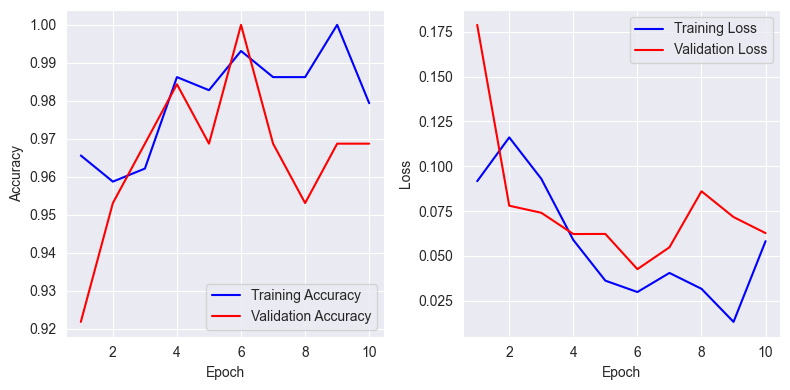

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9684 - loss: 0.1266
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9473 - loss: 0.2345
Original Test Set Accuracy      : 96.83%
Crop + Padded Test Set Accuracy : 93.65%


In [29]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Unfreeze LAST 5 layers for fine-tuning
for layer in VGGmodel.layers[-5:]:
    layer.trainable = True

# Recompile with a lower learning rate
VGGmodel.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again
history = VGGmodel.fit(train_generator, validation_data= val_generator, epochs=10)

# Plotting the accuracy/epoch loss
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1,len(acc2) +1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (8,4))
axes[0].plot(epochs, acc2, 'b', label= 'Training Accuracy')
axes[0].plot(epochs, val_acc2, 'r', label= 'Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label= 'Training Loss')
axes[1].plot(epochs, val_loss2, 'r', label= 'Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = VGGmodel.evaluate(ori_generator)
stress_loss, stress_acc = VGGmodel.evaluate(cropPadded_generator)
print("================================")
print(f"Original Test Set Accuracy      : {test_acc* 100:.2f}%")
print(f"Crop + Padded Test Set Accuracy : {stress_acc* 100:.2f}%")
print("================================")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


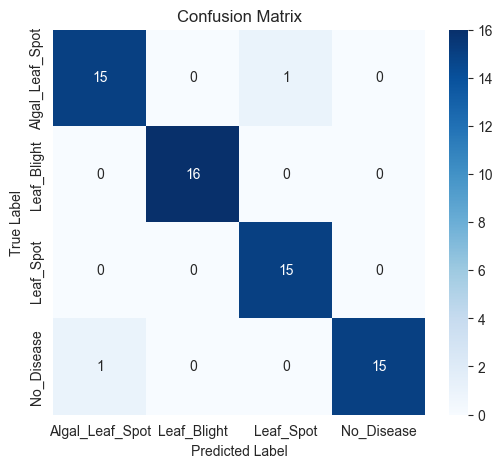

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.94      0.94      0.94        16
    Leaf_Blight       1.00      1.00      1.00        16
      Leaf_Spot       0.94      1.00      0.97        15
     No_Disease       1.00      0.94      0.97        16

       accuracy                           0.97        63
      macro avg       0.97      0.97      0.97        63
   weighted avg       0.97      0.97      0.97        63



In [30]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = ori_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(ori_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = VGGmodel.predict(ori_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

In [12]:
from tensorflow.keras.models import load_model

VGGmodel = load_model("model/VGG19_model.keras")
stress_loss, stress_acc = VGGmodel.evaluate(stressTest_generator)

print("=======================================")
print(f"Stress Test Set Accuracy : {stress_acc* 100:.2f}%")
print("=======================================")

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9264 - loss: 0.2630
Stress Test Set Accuracy : 93.25%


In [31]:
VGGmodel.save("model/VGG19_model.keras")
VGGmodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,299,918 (149.92 MB)

 Trainable params: 9,571,588 (36.51 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

 Optimizer params: 19,143,178 (73.03 MB)

In [32]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model('VGG19_model.keras')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
with open('model/VGG19_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Travi\AppData\Local\Temp\tmpdclo4j42\assets


INFO:tensorflow:Assets written to: C:\Users\Travi\AppData\Local\Temp\tmpdclo4j42\assets


Saved artifact at 'C:\Users\Travi\AppData\Local\Temp\tmpdclo4j42'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2093926266256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090807311824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090807311056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090807302992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090807309136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094118798736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094118798160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094118799504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094118797584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094118800272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094